# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                     
Sample_097  Q8IWV2                                                17.043
Sample_004  A0A087WTA1;A0A0A0MR20;E9PDN6;F5H107;Q9C0A0;Q9C0A0-2   17.557
Sample_058  Q9NRB3                                                13.738
Sample_105  Q13217;X6R9L0                                         16.341
Sample_131  Q15121;Q15121-2                                       13.897
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups 
Sample_141  Q8WYK1            15.555
Sample_128  O60512            11.938
Sample_143  O75636;O75636-2   14.436
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.637
            A0A075B6Q5                 12.868
            A0A075B6R2                 12.312
            A0A075B6S5                 13.273
            A0A087WSY4                 12.295
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.685
            Q9UI40;Q9UI40-2            14.392
            Q9UIW2                     13.693
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.604
            Q9UP79                     12.047
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.177,15.050,16.842,19.863,15.432,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.729,19.067,...,15.528,15.576,14.242,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.369,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.330,17.705,17.039,16.269,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.840,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.245,15.345,17.084,18.708,14.249,19.433,11.865,11.606
Sample_207,15.739,16.877,15.469,16.898,14.975,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.298,12.313,13.977,14.345,13.746,13.515,12.112,12.311,12.257,13.930
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.063,19.067,16.127,...,11.291,12.514,13.216,13.283,12.318,11.042,12.836,12.793,11.744,12.466
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.880,12.382,11.297,14.201,12.513,12.299,13.062,13.077,12.187,12.841
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.200,13.008,12.155,13.007,11.318,13.906,14.074,14.531,12.661,13.644
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.493,13.195,13.257,12.235,13.130,12.284,14.017,12.553,12.537,13.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.344,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.36it/s]

100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.55it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]

100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.89it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.67it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.82it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.41it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.27it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.40it/s]

100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.66it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.10it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.45it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.65it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.12it/s]

100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.81it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.54it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.31it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.01it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.42it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.42it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.42it/s]

100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.45it/s]

 30%|███       | 3/10 [00:00<00:01,  5.20it/s]

 40%|████      | 4/10 [00:00<00:01,  4.20it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.72it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.20it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.88it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.83it/s]

100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.58it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.52it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.94it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.46it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.37it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.32it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.39it/s]

100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

100%|██████████| 11/11 [00:02<00:00,  4.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.69it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.63it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.61it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.44it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.31it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.36it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.43it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.46it/s]

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

100%|██████████| 12/12 [00:02<00:00,  4.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.70it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.18it/s]

 31%|███       | 4/13 [00:00<00:01,  5.44it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.95it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.89it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.70it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.85it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.73it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.73it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.74it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.75it/s]

100%|██████████| 13/13 [00:02<00:00,  4.80it/s]

100%|██████████| 13/13 [00:02<00:00,  4.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.24it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.64it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.33it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.38it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.21it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.08it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.00it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.91it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.00it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.21it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.52it/s]

100%|██████████| 14/14 [00:04<00:00,  3.82it/s]

100%|██████████| 14/14 [00:04<00:00,  3.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.67it/s]

 20%|██        | 3/15 [00:00<00:02,  4.53it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.26it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.27it/s]

 40%|████      | 6/15 [00:01<00:02,  4.48it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.29it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.38it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.29it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.46it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.69it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.42it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.20it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.13it/s]

100%|██████████| 15/15 [00:03<00:00,  3.26it/s]

100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.046 0.016          0.731 0.366       0.104   
2             0.005 0.006      0.058 0.025          0.710 0.091       0.601   
3             0.004 0.002      0.037 0.009          0.718 0.086       0.653   
4             0.004 0.003      0.047 0.020          0.710 0.079       0.676   
5             0.005 0.003      0.053 0.023          0.727 0.084       0.694   
6             0.003 0.000      0.036 0.004          0.792 0.087       0.816   
7             0.006 0.005      0.059 0.030          0.794 0.086       0.825   
8             0.007 0.007      0.076 0.033          0.817 0.082       0.815   
9             0.006 0.006      0.065 0.029          0.799 0.076       0.833   
10            0.002 0.001      0.024 0.009          0.807 0.081       0.840   
11            0.003 0.001      0.027 0.008          0.800 0.085       0.841   
12            0.004 0.001      0.036 0.008          0.807 0.082       0.838   
13            0.004 0.002      0.037 0.008          0.802 0.083       0.835   
14            0.004 0.002      0.039 0.010          0.799 0.082       0.836   
15            0.004 0.000      0.036 0.007          0.803 0.086       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.175 0.125                  0.544 0.038        0.847   
2          0.103   0.645 0.079                  0.709 0.058        0.779   
3          0.113   0.677 0.080                  0.730 0.059        0.799   
4          0.115   0.686 0.076                  0.735 0.057        0.797   
5          0.112   0.703 0.072                  0.749 0.056        0.807   
6          0.103   0.799 0.070                  0.827 0.062        0.893   
7          0.105   0.804 0.070                  0.832 0.061        0.893   
8          0.111   0.811 0.076                  0.840 0.065        0.909   
9          0.104   0.812 0.070                  0.839 0.061        0.911   
10         0.100   0.819 0.071                  0.845 0.063        0.911   
11         0.107   0.816 0.075                  0.842 0.067        0.909   
12         0.106   0.818 0.073                  0.844 0.064        0.907   
13         0.103   0.815 0.075                  0.841 0.066        0.906   
14         0.105   0.813 0.072                  0.840 0.064        0.904   
15         0.097   0.813 0.066                  0.839 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.088        210.000 0.000  
2          0.067                  0.757 0.085        210.000 0.000  
3          0.067                  0.767 0.088        210.000 0.000  
4          0.063                  0.761 0.084        210.000 0.000  
5          0.063                  0.778 0.083        210.000 0.000  
6          0.052                  0.867 0.060        210.000 0.000  
7          0.051                  0.866 0.061        210.000 0.000  
8          0.050                  0.898 0.050        210.000 0.000  
9          0.052                  0.902 0.049        210.000 0.000  
10         0.052                  0.904 0.049        210.000 0.000  
11         0.054                  0.901 0.051        210.000 0.000  
12         0.053                  0.897 0.051        210.000 0.000  
13         0.054                  0.897 0.052        210.000 0.000  
14         0.054                  0.895 0.051        210.000 0.000  
15         0.052                  0.893 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 521.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.76it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.66it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.34it/s]

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

100%|██████████| 5/5 [00:01<00:00,  4.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.55it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.03it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.62it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.47it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.89it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.87it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.54it/s]

100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.53it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.97it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.63it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.01it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.18it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.33it/s]

100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.73it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.52it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.98it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.76it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.60it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.54it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.71it/s]

 30%|███       | 3/10 [00:00<00:01,  4.67it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.53it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.84it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.88it/s]

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.03it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.37it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.85it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.70it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.73it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.83it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.87it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.76it/s]

100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

100%|██████████| 11/11 [00:02<00:00,  4.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.47it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.32it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.28it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.93it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.95it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.32it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.90it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  3.91it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.03it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.00it/s]

100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.25it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.86it/s]

 31%|███       | 4/13 [00:00<00:01,  4.50it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.97it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.67it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.68it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.67it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.68it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.58it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.56it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.87it/s]

100%|██████████| 13/13 [00:03<00:00,  3.92it/s]

100%|██████████| 13/13 [00:03<00:00,  3.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.02it/s]

 21%|██▏       | 3/14 [00:00<00:01,  7.01it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.73it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.19it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.90it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.65it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.71it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.29it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.65it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.20it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.01it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.84it/s]

100%|██████████| 14/14 [00:03<00:00,  2.87it/s]

100%|██████████| 14/14 [00:03<00:00,  3.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.06it/s]

 20%|██        | 3/15 [00:00<00:02,  4.12it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.70it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.74it/s]

 40%|████      | 6/15 [00:01<00:02,  3.67it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.72it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  4.05it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.12it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.07it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.02it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.97it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.08it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.05it/s]

100%|██████████| 15/15 [00:03<00:00,  3.59it/s]

100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.005      0.040 0.014          0.010 0.071       0.001   
2             0.004 0.004      0.048 0.018          0.804 0.095       0.712   
3             0.004 0.005      0.049 0.020          0.782 0.103       0.709   
4             0.005 0.006      0.050 0.017          0.784 0.083       0.734   
5             0.008 0.009      0.063 0.025          0.768 0.089       0.742   
6             0.007 0.008      0.063 0.022          0.765 0.093       0.744   
7             0.004 0.003      0.041 0.014          0.761 0.093       0.740   
8             0.003 0.003      0.029 0.016          0.761 0.093       0.738   
9             0.004 0.002      0.041 0.015          0.754 0.096       0.733   
10            0.004 0.003      0.037 0.014          0.791 0.097       0.751   
11            0.004 0.003      0.047 0.019          0.832 0.097       0.783   
12            0.003 0.000      0.040 0.012          0.831 0.098       0.781   
13            0.004 0.002      0.033 0.007          0.831 0.085       0.812   
14            0.004 0.002      0.036 0.007          0.836 0.075       0.806   
15            0.005 0.004      0.047 0.017          0.848 0.081       0.820   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.862   
2          0.110   0.749 0.080                  0.791 0.062        0.867   
3          0.113   0.737 0.082                  0.779 0.066        0.878   
4          0.109   0.754 0.078                  0.792 0.063        0.901   
5          0.104   0.750 0.075                  0.787 0.063        0.900   
6          0.105   0.749 0.077                  0.786 0.065        0.898   
7          0.102   0.746 0.077                  0.783 0.065        0.896   
8          0.106   0.744 0.079                  0.782 0.067        0.894   
9          0.112   0.738 0.082                  0.777 0.068        0.893   
10         0.110   0.765 0.082                  0.801 0.067        0.916   
11         0.098   0.802 0.076                  0.831 0.063        0.925   
12         0.100   0.800 0.077                  0.830 0.065        0.924   
13         0.089   0.817 0.065                  0.844 0.056        0.928   
14         0.077   0.818 0.057                  0.844 0.048        0.931   
15         0.081   0.830 0.057                  0.854 0.049        0.932   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.826 0.087        210.000 0.000  
2          0.061                  0.837 0.083        210.000 0.000  
3          0.051                  0.851 0.069        210.000 0.000  
4          0.044                  0.880 0.052        210.000 0.000  
5          0.047                  0.880 0.054        210.000 0.000  
6          0.047                  0.878 0.055        210.000 0.000  
7          0.049                  0.876 0.056        210.000 0.000  
8          0.049                  0.874 0.057        210.000 0.000  
9          0.052                  0.872 0.059        210.000 0.000  
10         0.047                  0.896 0.058        210.000 0.000  
11         0.043                  0.906 0.057        210.000 0.000  
12         0.043                  0.904 0.056        210.000 0.000  
13         0.043                  0.908 0.051        210.000 0.000  
14         0.041                  0.912 0.049        210.000 0.000  
15         0.041                  0.914 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1057.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.74it/s]

100%|██████████| 3/3 [00:00<00:00, 24.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.41it/s]

100%|██████████| 4/4 [00:00<00:00, 16.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.49it/s]

100%|██████████| 5/5 [00:00<00:00, 17.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.00it/s]

100%|██████████| 6/6 [00:00<00:00, 17.08it/s]

100%|██████████| 6/6 [00:00<00:00, 17.57it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.90it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.91it/s]

100%|██████████| 7/7 [00:00<00:00, 12.59it/s]

100%|██████████| 7/7 [00:00<00:00, 13.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.88it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.59it/s]

100%|██████████| 8/8 [00:00<00:00, 17.02it/s]

100%|██████████| 8/8 [00:00<00:00, 17.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.90it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.83it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.75it/s]

100%|██████████| 9/9 [00:00<00:00, 14.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.32it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.23it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.73it/s]

100%|██████████| 10/10 [00:00<00:00, 15.43it/s]

100%|██████████| 10/10 [00:00<00:00, 15.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.77it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.80it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.45it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.10it/s]

100%|██████████| 11/11 [00:00<00:00, 13.68it/s]

100%|██████████| 11/11 [00:00<00:00, 13.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.01it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.35it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.62it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.38it/s]

100%|██████████| 12/12 [00:00<00:00, 12.85it/s]

100%|██████████| 12/12 [00:00<00:00, 13.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.14it/s]

 38%|███▊      | 5/13 [00:00<00:00, 16.54it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.80it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.45it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.15it/s]

100%|██████████| 13/13 [00:00<00:00, 14.78it/s]

100%|██████████| 13/13 [00:00<00:00, 14.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.35it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.12it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.65it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.52it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.82it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.36it/s]

100%|██████████| 14/14 [00:00<00:00, 14.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 25.44it/s]

 40%|████      | 6/15 [00:00<00:00, 17.02it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.33it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.38it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.86it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.18it/s]

100%|██████████| 15/15 [00:01<00:00, 14.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.045 0.016          0.000 0.000       0.000   
2             0.004 0.005      0.036 0.007          0.567 0.118       0.368   
3             0.004 0.002      0.045 0.016          0.656 0.123       0.488   
4             0.003 0.001      0.037 0.007          0.662 0.121       0.510   
5             0.005 0.005      0.050 0.019          0.638 0.122       0.522   
6             0.004 0.002      0.037 0.008          0.638 0.123       0.522   
7             0.005 0.005      0.047 0.016          0.625 0.121       0.510   
8             0.005 0.004      0.049 0.019          0.699 0.093       0.593   
9             0.004 0.003      0.038 0.008          0.734 0.088       0.647   
10            0.005 0.004      0.049 0.018          0.728 0.086       0.636   
11            0.003 0.001      0.038 0.009          0.718 0.091       0.623   
12            0.005 0.004      0.046 0.015          0.719 0.093       0.635   
13            0.004 0.003      0.036 0.008          0.706 0.089       0.669   
14            0.004 0.002      0.045 0.016          0.700 0.090       0.665   
15            0.005 0.005      0.058 0.027          0.690 0.091       0.652   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.728   
2          0.106   0.440 0.104                  0.581 0.066        0.669   
3          0.108   0.553 0.098                  0.648 0.068        0.714   
4          0.102   0.570 0.093                  0.657 0.069        0.709   
5          0.106   0.567 0.093                  0.649 0.073        0.709   
6          0.101   0.567 0.089                  0.648 0.070        0.703   
7          0.100   0.555 0.087                  0.639 0.068        0.703   
8          0.115   0.637 0.094                  0.703 0.070        0.789   
9          0.103   0.682 0.074                  0.736 0.058        0.810   
10         0.104   0.673 0.077                  0.729 0.058        0.809   
11         0.100   0.662 0.078                  0.720 0.059        0.807   
12         0.103   0.669 0.081                  0.725 0.062        0.805   
13         0.105   0.682 0.084                  0.732 0.066        0.808   
14         0.106   0.677 0.086                  0.727 0.068        0.804   
15         0.110   0.666 0.091                  0.719 0.070        0.801   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.675 0.083        210.000 0.000  
2          0.081                  0.627 0.091        210.000 0.000  
3          0.075                  0.668 0.094        210.000 0.000  
4          0.079                  0.668 0.097        210.000 0.000  
5          0.076                  0.670 0.092        210.000 0.000  
6          0.076                  0.664 0.093        210.000 0.000  
7          0.077                  0.661 0.095        210.000 0.000  
8          0.062                  0.737 0.078        210.000 0.000  
9          0.061                  0.764 0.075        210.000 0.000  
10         0.060                  0.762 0.076        210.000 0.000  
11         0.060                  0.757 0.076        210.000 0.000  
12         0.061                  0.757 0.076        210.000 0.000  
13         0.063                  0.759 0.076        210.000 0.000  
14         0.066                  0.756 0.079        210.000 0.000  
15         0.066                  0.752 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,5,7
score_time,8,5,15
test_precision,8,15,9
test_recall,11,15,13
test_f1,10,15,13
test_balanced_accuracy,10,15,9
test_roc_auc,10,15,9
test_average_precision,10,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.84it/s]

 20%|██        | 3/15 [00:00<00:02,  4.67it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.01it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.75it/s]

 40%|████      | 6/15 [00:01<00:02,  3.52it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.43it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.32it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.67it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.69it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.25it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.93it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.83it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.96it/s]

100%|██████████| 15/15 [00:04<00:00,  3.22it/s]

100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.95it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.27it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.45it/s]

100%|██████████| 9/9 [00:00<00:00, 15.65it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.88it/s]

 30%|███       | 3/10 [00:00<00:01,  4.71it/s]

 40%|████      | 4/10 [00:00<00:01,  3.78it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.75it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.39it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.02it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.95it/s]

100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


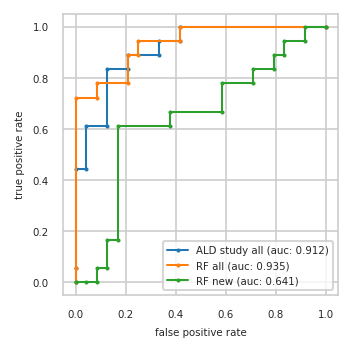

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.000 0.722  0.083 0.000
3          0.042 0.444  0.083 0.722  0.083 0.056
4          0.042 0.611  0.083 0.778  0.125 0.056
5          0.125 0.611  0.208 0.778  0.125 0.167
6          0.125 0.833  0.208 0.889  0.167 0.167
7          0.208 0.833  0.250 0.889  0.167 0.611
8          0.208 0.889  0.250 0.944  0.375 0.611
9          0.333 0.889  0.417 0.944  0.375 0.667
10         0.333 0.944  0.417 1.000  0.583 0.667
11         0.417 0.944  1.000 1.000  0.583 0.778
12         0.417 1.000    NaN   NaN  0.708 0.778
13         1.000 1.000    NaN   NaN  0.708 0.833
14           NaN   NaN    NaN   NaN  0.792 0.833
15           NaN   NaN    NaN   NaN  0.792 0.889
16           NaN   NaN    NaN   NaN  0.833 0.889
17           NaN   NaN    NaN   NaN  0.833 0.944
18           NaN   NaN    NaN   NaN  0.917 0.944
19           NaN   NaN    NaN   NaN  0.917 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,P26572,E5RK69;E7EMC6;P08133;P08133-2
2,P01258;P01258-2;P06881,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,A6H8L4;E7EUI5;P78536;P78536-2
3,P61981,P05023;P05023-4,J3KSJ8;Q9UD71;Q9UD71-2
4,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,Q9Y2T3;Q9Y2T3-3,P31321
6,Q9Y2T3;Q9Y2T3-3,P61981,Q96GD0
7,P08294,P14174,P51688
8,P00338;P00338-3,P63104,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


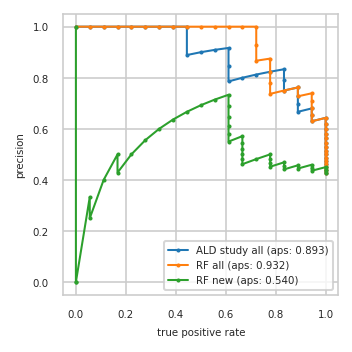

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.643 1.000     0.643 1.000     0.500 0.778
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.654 0.944     0.462 0.667
17         0.680 0.944     0.680 0.944     0.480 0.667
18         0.667 0.889     0.708 0.944     0.500 0.667
19         0.696 0.889     0.739 0.944     0.522 0.667
20         0.727 0.889     0.727 0.889     0.545 0.667
21         0.762 0.889     0.762 0.889     0.571 0.667
22         0.750 0.833     0.750 0.833     0.550 0.611
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.833 0.833     0.778 0.778     0.611 0.611
25         0.824 0.778     0.824 0.778     0.647 0.611
26         0.812 0.722     0.875 0.778     0.688 0.611
27         0.800 0.667     0.867 0.722     0.733 0.611
28         0.786 0.611     0.929 0.722     0.714 0.556
29         0.846 0.611     1.000 0.722     0.692 0.500
30         0.917 0.611     1.000 0.667     0.667 0.444
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


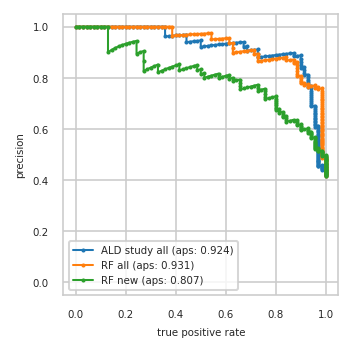

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


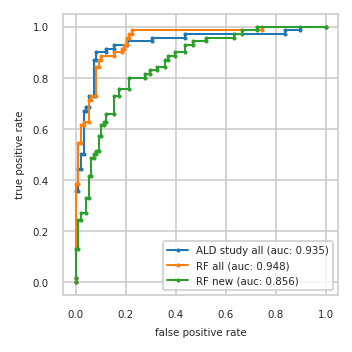

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}